# Ewaluacja predykcji szeregów czasowych

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from ts_utils import check_time_series_stationary
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

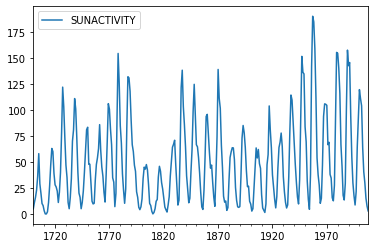

In [2]:
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
sunspots = sunspots.drop('YEAR', axis=1)

sunspots.plot()

### Podział na część treningową i część testową

Ocena dokładności na podstawie tych samych danych, które były wykorzystane do konstrukcji prognozu, nie pozwala na w pełni wiarygodną ocenę skuteczności i może prowadzić do błędnych wniosków. Aby wiarygodnie porównać skuteczność różnych metod prognozowania, powinniśmy wykorzystać niezależne dane testowe.

W tym celu szereg dzielimy na:
- **część treningową** - wykorzystaną do dopasowania modelu i konstrukcji prognoz,
- **część testową** - wykorzystaną do oceny dokładności prognoz.

In [4]:
k = int(sunspots.size * 0.8)

sunspots_train = sunspots[:k]
sunspots_test = sunspots[k:]

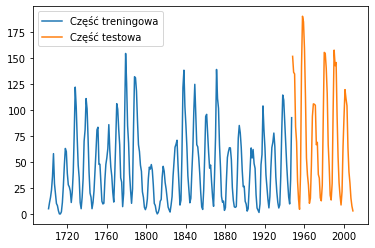

In [6]:
plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.legend()
plt.show()

In [8]:
sunspots_test.index

DatetimeIndex(['1947-12-31', '1948-12-31', '1949-12-31', '1950-12-31',
               '1951-12-31', '1952-12-31', '1953-12-31', '1954-12-31',
               '1955-12-31', '1956-12-31', '1957-12-31', '1958-12-31',
               '1959-12-31', '1960-12-31', '1961-12-31', '1962-12-31',
               '1963-12-31', '1964-12-31', '1965-12-31', '1966-12-31',
               '1967-12-31', '1968-12-31', '1969-12-31', '1970-12-31',
               '1971-12-31', '1972-12-31', '1973-12-31', '1974-12-31',
               '1975-12-31', '1976-12-31', '1977-12-31', '1978-12-31',
               '1979-12-31', '1980-12-31', '1981-12-31', '1982-12-31',
               '1983-12-31', '1984-12-31', '1985-12-31', '1986-12-31',
               '1987-12-31', '1988-12-31', '1989-12-31', '1990-12-31',
               '1991-12-31', '1992-12-31', '1993-12-31', '1994-12-31',
               '1995-12-31', '1996-12-31', '1997-12-31', '1998-12-31',
               '1999-12-31', '2000-12-31', '2001-12-31', '2002-12-31',
      

In [ ]:
#fit_ARMA(sunspots, 4, 2, '1990', '2012')

In [9]:
arma42 = ARIMA(sunspots_train, order=(4, 0, 2)).fit()
arma42_predict = arma42.predict(start='1947', end='2008', dynamic=True)

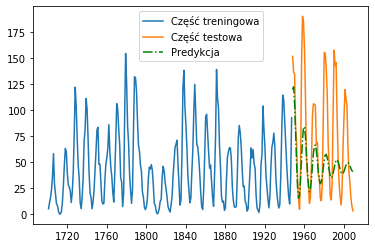

In [10]:
plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.plot(arma42_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

## Zadanie 1

Napisz funkcję, która znajdzie najlepszy model ARMA - pamiętaj o podziale zbioru na część treningową i testową.

In [12]:
def mse(y, yhat):
    return np.mean((y - yhat) ** 2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))

In [24]:
def find_the_best_arma(ts, max_p = 10, max_q=10, split=0.8):
    
    k = int(ts.size * split)
    ts_train = ts[:k]
    ts_test = ts[k:]

    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    mse2 = np.zeros((max_p, max_q))
    mae2 = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            try:
                arma = ARIMA(ts_train, order=(i + 1, 0, j + 1)).fit()
                aic[i, j] = arma.aic
                bic[i, j] = arma.bic
                print('ARMA(%d, %d): AIC=%f, BIC=%f' % (i+1, j+1, arma.aic, arma.bic))

                arma_pred = arma.predict(start=str(np.min(ts_test.index).year), end=str(np.max(ts_test.index).year), 
                                         dynamic=True)
                mse2[i, j] = mse(ts_test.values, arma_pred.values)
                mae2[i, j] = mae(ts_test.values, arma_pred.values)
            except:
                aic[i, j] = bic[i, j] = mse2[i, j] = mae2[i, j] = np.Inf
            
    print("-" * 30)
    min_aic = np.min(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0]
    print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
    min_bic = np.min(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0]
    print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))
    
    min_mse = np.min(mse2)
    min_arg_mse = np.argwhere(mse2 == min_mse)[0]
    print("MINIMUM MSE=%f dla p=%d, q=%d" % (min_mse, min_arg_mse[0] + 1, min_arg_mse[1] + 1))
    
    min_mae = np.min(mae2)
    min_arg_mae = np.argwhere(mae2 == min_mae)[0]
    print("MINIMUM MAE=%f dla p=%d, q=%d" % (min_mae, min_arg_mae[0] + 1, min_arg_mae[1] + 1))

In [25]:
find_the_best_arma(sunspots, 5, 5)

ARMA(1, 1): AIC=2106.036510, BIC=2120.074064
ARMA(1, 2): AIC=2070.118592, BIC=2087.665534
ARMA(1, 3): AIC=2065.739210, BIC=2086.795540
ARMA(1, 4): AIC=2062.390795, BIC=2086.956514
ARMA(1, 5): AIC=2060.321158, BIC=2088.396265
ARMA(2, 1): AIC=2039.591641, BIC=2057.138583
ARMA(2, 2): AIC=2041.541968, BIC=2062.598298
ARMA(2, 3): AIC=2043.524369, BIC=2068.090088
ARMA(2, 4): AIC=2031.548344, BIC=2059.623450
ARMA(3, 1): AIC=2040.483338, BIC=2061.539668
ARMA(3, 2): AIC=2042.359549, BIC=2066.925267
ARMA(3, 3): AIC=2043.738003, BIC=2071.813110
ARMA(3, 4): AIC=2018.724167, BIC=2050.308662
ARMA(3, 5): AIC=2033.804698, BIC=2068.898581
ARMA(4, 1): AIC=2042.393166, BIC=2066.958885
ARMA(4, 2): AIC=2018.456907, BIC=2046.532013
ARMA(4, 3): AIC=2044.777291, BIC=2076.361786
ARMA(4, 4): AIC=2018.446382, BIC=2053.540265
ARMA(4, 5): AIC=2021.458067, BIC=2060.061338
ARMA(5, 1): AIC=2043.183914, BIC=2071.259020
ARMA(5, 2): AIC=2034.727663, BIC=2066.312158
ARMA(5, 3): AIC=2026.914281, BIC=2062.008164
ARMA(5, 4)

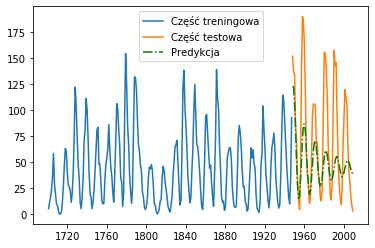

In [27]:
arma55 = ARIMA(sunspots_train, order=(5, 0, 5)).fit()
arma55_predict = arma55.predict(start='1947', end='2008', dynamic=True)

plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.plot(arma55_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

## Kroswalidacja

In [13]:
from sklearn.model_selection import TimeSeriesSplit

## Zadanie 2

Napisz funkcję, która znajdzie najlepszy model ARMA - użyj kroswalidacji.

# Predykcja z wykorzystaniem danych historycznych